In [8]:
%reset -f
%matplotlib inline

from os import listdir
import os


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import preprocessing # for normalization of confounds columns

from nilearn import datasets, plotting, input_data, signal  # for fetching atlas

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_design_matrix

from fctools import denoise

In [9]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    #smoothing_fwhm = 6, 
    radius = 5,
    detrend = False, 
    standardize = True,
    #low_pass = 0.25, 
    #high_pass = 0.008,
    t_r = 2
)

parcellation = power_spheres

In [10]:
# Loading functional data
top_dir = '/media/finc/Elements/LearningBrain_fmriprep/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/'

sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
#tasks = ['rest']
tasks = ['dualnback']
#subs = listdir(top_dir)

suffix = 'space-MNI152NLin2009cAsym_preproc.nii.gz'

# Selecting subjects which finished the study

groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]['sub']
subs = pd.Series.tolist(trained_subs)
subs[:5]


['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-06']

In [11]:
t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv'

events = pd.read_csv(onsets_dir)

frame_times = np.arange(n_scans) * t_r

#------ step 1
box = make_design_matrix(frame_times, events, hrf_model = None)
box = box.reset_index()

# ----- step 2

box_hrf = make_design_matrix(frame_times, events, hrf_model = 'spm')
box_hrf  = box_hrf.reset_index()


/home/finc/anaconda/lib/python3.6/site-packages/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


In [4]:
timeseries_all = np.zeros((len(subs), len(sess), 340, 264))

for sub in range(len(subs)):
    for ses in range(len(sess)):
        for task in range(len(tasks)):
            
            sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'
            sub_name = subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] 
            data = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_' + suffix
            
            # Loading confound data
            confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            
            if not os.path.exists(confounds_path):
                print(f"{subs[sub]} {sess[ses]} {tasks[task]} does not exist")
            else:
                
                confounds = pd.read_csv(confounds_path, delimiter = '\t')
                confounds.to_csv(out_dir + 'confounds/' + sub_name + '_bold_confounds.csv', sep = ',', index = False)

                # Select columns of interest 
                confounds_motion = confounds[confounds.filter(regex = 'X|Y|Z|RotX|RotY|RotZ').columns]
                confounds_anat = confounds[confounds.filter(regex = 'CSF|WhiteMatter|aCompCor').columns]
                confounds_fd =  confounds[confounds.filter(regex = 'Framewise').columns]
                confounds_dvars =  confounds[confounds.filter(regex = 'vx-wisestdDVARS').columns]

                # Calculate 24 motion parameters
                confounds_motion_12 =  denoise.temp_deriv(confounds_motion)

                # Detect outliers 
                outliers_fd = denoise.temp_deriv(denoise.scrubbing(confounds_fd, thr = 0.5, before = False, after = False))
                outliers_dvars = denoise.temp_deriv(denoise.scrubbing(confounds_dvars, thr = 3, before = False, after = False))

                # Standardize confounds
                
                detrend = pd.DataFrame(np.arange(340))
                detrend.columns = ['lin_trend']
                
                # Add scrubbing columns
                confounds_clean = pd.concat([confounds_anat, confounds_motion_12, confounds_scrub, pd.DataFrame(box_hrf, columns = ['intro', '1-back', '2-back']), detrend], axis = 1)

                # Save preprocessed confound file
                confounds_clean.to_csv(out_dir + 'confounds/' + sub_name + '_clean_acompcor.csv', sep = ',', index = False)
                confounds_clean_path = out_dir + 'confounds/' + sub_name + '_clean_acompcor.csv'

                timeseries = parcellation.fit_transform(data, confounds = confounds_clean_path)
                
                timeseries = signal.clean(timeseries, low_pass=0.25, high_pass=0.008, t_r=2)

                timeseries_all[sub, ses, :, :] = timeseries

                
np.save(out_dir + 'neuroimaging/' + 'LearningBrain_' + tasks[task] + '_conn_settings_12p_task_effects.npy', timeseries_all)

AttributeError: module 'fctools.denoise' has no attribute 'motion_temp_derivarives'

Testing for one subject
------------------------------

In [5]:
sub = 4
ses = 0
task = 0

sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'
sub_name = subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] 
data = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_' + suffix
            
# Loading confound data
confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            
if not os.path.exists(confounds_path):
    print(f"{subs[sub]} {sess[ses]} {tasks[task]} does not exist")

else:          
    confounds = pd.read_csv(confounds_path, delimiter = '\t')
    confounds.to_csv(out_dir + 'confounds/' + sub_name + '_bold_confounds.csv', sep = ',', index = False)

    # Select columns of interest 
    confounds_motion = confounds[confounds.filter(regex = 'X|Y|Z|RotX|RotY|RotZ').columns]
    confounds_anat = confounds[confounds.filter(regex = 'CSF|WhiteMatter|aCompCor').columns]
    confounds_fd =  confounds[confounds.filter(regex = 'Framewise').columns]

    # Calculate 24 fristom motion parameters
    #confounds_motion_24 =  denoise.motion_24_friston(confounds_motion)
    confounds_motion_12 =  denoise.motion_temp_derivarives(confounds_motion)

    # Detect outliers 
    confounds_scrub = denoise.scrubbing(confounds_fd, before = False)

    # Standardize confounds
    #confounds_anat = denoise.standardize(confounds_anat)
                
    detrend = pd.DataFrame(np.arange(340))
    detrend.columns = ['lin_trend']
    
    # pd.DataFrame(box_hrf, columns = ['1-back', '2-back'])
    # Add scrubbing columns
    confounds_clean = pd.concat([confounds_anat, confounds_motion_12, confounds_scrub, detrend], axis = 1)

    # Save preprocessed confound file
    confounds_clean.to_csv(out_dir + 'confounds/' + sub_name + '_clean_acompcor.csv', sep = ',', index = False)
    confounds_clean_path = out_dir + 'confounds/' + sub_name + '_clean_acompcor.csv'

    timeseries = parcellation.fit_transform(data, confounds = confounds_clean_path)
                
    timeseries = signal.clean(timeseries, low_pass=0.25, high_pass = 0.008, t_r=2)

AttributeError: module 'fctools.denoise' has no attribute 'motion_temp_derivarives'

In [12]:
sub = 0
ses = 0
task = 0

In [13]:
sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'

confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
sub_name = subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] 
data = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_' + suffix
confounds = pd.read_csv(confounds_path, delimiter = '\t')
confounds.to_csv(out_dir + 'confounds/' + sub_name + '_bold_confounds.csv', sep = ',', index = False)

In [32]:
confounds_motion = confounds[confounds.filter(regex = 'X|Y|Z|RotX|RotY|RotZ').columns]

In [15]:
x = denoise.temp_deriv(pd.DataFrame(box_hrf, columns = ['1-back', '2-back']), quadratic = True )

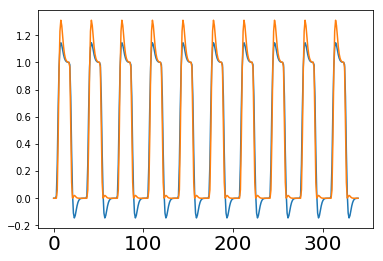

In [22]:
#plt.plot(x['1-back'])
plt.plot(x['1-back'])
plt.plot(x['1-back_sqrt'])

In [32]:
confounds

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,AROMAAggrComp64,AROMAAggrComp66,AROMAAggrComp67,AROMAAggrComp68,AROMAAggrComp69,AROMAAggrComp70,AROMAAggrComp71,AROMAAggrComp72,AROMAAggrComp73,AROMAAggrComp74
0,4992.474886,5090.469052,5046.218529,n/a,n/a,n/a,n/a,-0.030981,-0.005468,-0.018759,...,0.400181,0.946204,0.955886,-0.573036,1.095121,0.868360,1.699088,0.455087,1.282518,-0.613856
1,4988.908524,5074.919540,5036.091231,1.19033587,19.20129776,0.99637973,0.08790176000000001,-0.052983,0.025367,0.027136,...,1.005423,0.703278,2.240348,-1.099579,0.651699,-0.727541,-0.181392,-0.991720,0.991824,-0.459417
2,4985.519031,5080.433980,5053.796893,1.21364927,19.57736588,1.01850128,0.044172610000000015,-0.036149,-0.045575,-0.049409,...,-1.100690,2.184665,0.450661,0.574688,-0.124935,-0.877947,-1.508662,-0.263613,1.337509,-0.331542
3,5014.052495,5091.837698,5076.060893,1.24933183,20.15295982,0.96483594,0.07125526000000001,0.024995,-0.124297,0.033399,...,0.185901,2.140045,1.254504,1.987640,1.125272,1.075349,0.863794,-0.963607,0.980341,-2.039292
4,5009.006418,5096.263203,5064.712070,1.08524072,17.50600815,0.91124761,0.07154287499999999,0.021495,-0.043658,0.054384,...,0.353616,0.685129,1.821815,1.049765,-0.468607,0.019039,-0.140991,1.834558,0.644822,-1.706936
5,5011.198562,5095.261406,5055.173331,0.99207807,16.00320244,0.87127322,0.03763083500000001,0.027265,0.040059,0.073277,...,-1.151684,1.094336,2.176698,-0.387441,0.256264,-0.152967,-2.374172,-1.841003,-0.467572,-0.796203
6,4956.509452,5086.921141,5040.234639,1.15169191,18.57793236,0.94979095,0.0610732,-0.063734,0.050542,-0.070882,...,-0.467505,1.454923,0.821515,-0.254448,0.465114,1.071706,-0.877116,1.262562,-1.029843,-1.447533
7,4983.675854,5084.538992,5058.253472,1.06981456,17.25716972,0.92761678,0.054446565,-0.012220,0.007307,0.030690,...,0.267933,1.762421,1.748356,-0.393467,0.286131,0.409309,0.000418,-1.980378,-0.199810,-1.689243
8,4987.015076,5090.757774,5054.340100,0.97154206,15.67193604,0.88557011,0.075207865,0.016072,0.029984,0.072163,...,0.956520,0.212693,1.415601,0.115164,-0.337609,-0.178499,0.259195,1.431744,0.260085,-2.129343
9,4971.468798,5086.638085,5040.099628,1.03369689,16.67455482,0.90774524,0.098651605,-0.008471,0.106501,0.021099,...,-0.706751,-0.831301,1.115608,-0.588799,0.436531,-0.065102,-1.498179,-1.849871,0.123954,-0.608895


In [24]:
confounds_dvars =  confounds[confounds.filter(regex = 'vx-wisestdDVARS').columns]

In [31]:
confounds_dvars['vx-wisestdDVARS'].values

array(['n/a', '0.99637973', '1.01850128', '0.96483594', '0.91124761',
       '0.87127322', '0.94979095', '0.92761678', '0.88557011',
       '0.90774524', '0.93054861', '0.9319874', '0.92212594', '0.94835192',
       '0.90178841', '0.92890167', '0.96663147', '1.03176022',
       '1.11784649', '1.14289439', '0.9891578', '0.967273', '0.92221075',
       '0.94338238', '0.89426631', '0.93343014', '0.91636986',
       '0.90943795', '0.92842275', '0.91326272', '0.89646161',
       '0.92828864', '1.00429785', '0.94308698', '0.91297722',
       '0.95955968', '0.96617568', '0.98021001', '0.97362632',
       '0.95462823', '0.92712712', '0.95208514', '0.97864848',
       '0.98365819', '1.04348433', '0.92448652', '0.90082204',
       '0.96752501', '0.96773523', '0.97276539', '1.00773311',
       '1.30319262', '2.24873662', '2.22162151', '1.47036576',
       '1.18352747', '1.04317689', '0.95499843', '0.94414318',
       '0.93759316', '0.93271577', '0.93829137', '0.92827934',
       '0.90900403', '0.

In [76]:
dataframe = confounds[confounds.filter(regex = 'vx-wisestdDVARS|Framewise').columns]

In [77]:
def oultliers_fd_dvars(dataframe, fd = 0.5, dvars = 3):

    temp = pd.DataFrame()
    dataframe.loc[0] = 0


    dvars_out = dataframe[dataframe.columns[0]].astype(float) > dvars
    fd_out = dataframe[dataframe.columns[1]].astype(float) > fd

    outliers = (dvars_out == True) | (fd_out == True)
    outliers = pd.DataFrame(outliers.astype('int'))
    outliers.columns = ['scrubbing']

    return outliers




In [81]:
x = oultliers_fd_dvars(dataframe)

/home/finc/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/finc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


7

In [51]:
fd = 0.5
dvars = 3

In [55]:
dvars_out = dataframe[dataframe.columns[0]].astype(float) > dvars
fd_out = dataframe[dataframe.columns[1]].astype(float) > fd

In [62]:
outliers = (dvars_out == True) | (fd_out == True)

In [69]:
sum(outliers.astype('int'))

7

In [41]:
dataframe

,vx-wisestdDVARS,FramewiseDisplacement
0,0,0
1,0.99637973,0.08790176000000001
2,1.01850128,0.044172610000000015
3,0.96483594,0.07125526000000001
4,0.91124761,0.07154287499999999
5,0.87127322,0.03763083500000001
6,0.94979095,0.0610732
7,0.92761678,0.054446565
8,0.88557011,0.075207865
9,0.90774524,0.098651605
